**Task1: A.	Perform data preprocessing and exploratory data analysis.**

**Importing packages**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import joblib
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
import sklearn

import warnings
warnings.filterwarnings("ignore")

import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [ ]:
# PATH
path = '/content/drive/MyDrive/AI/dataset2'


calendar = pd.read_csv(path + '/calendar.csv')
selling_prices = pd.read_csv(path +'/sell_prices.csv')
sample_submission = pd.read_csv(path + '/sample_submission.csv')
sales_train_val = pd.read_csv(path + '/sales_train_validation.csv')

In [ ]:
print(selling_prices.head(), calendar.head(), sample_submission.head(), sales_train_val.head())

  store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26          date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0  

In [ ]:
ids = sorted(list(set(sales_train_val['id'])))
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[0]].set_index('id')[d_cols].values[0][:90]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[4]].set_index('id')[d_cols].values[0][1300:1400]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[65]].set_index('id')[d_cols].values[0][350:450]
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines+markers', name="First sample",
                         marker=dict(color="mediumseagreen")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines+markers', name="Second sample",
                         marker=dict(color="violet")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines+markers', name="Third sample",
                         marker=dict(color="dodgerblue")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales snippets")
fig.show()

# **Shrinking the data**

In [ ]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales_train_val)
prices = downcast(selling_prices)
calendar = downcast(calendar)

# **B.Feature engineering**

# **FEATURE SELECTION**

In [ ]:
from sklearn.preprocessing import LabelEncoder

nonservingcols = ["wm_yr_wk", "wday"]
dates = calendar.drop(nonservingcols, axis = 1)
dates["Date"] = dates.index
dates.index = dates["d"]
dates = dates.fillna(0)

categorical_cols = ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
my_labeler = LabelEncoder()
for i in categorical_cols:
    dates[i] = my_labeler.fit_transform(dates[i].astype("str"))


def createFeatures(series):
    serie = series.transpose()
    df_products = pd.merge(serie, dates, left_index= True, right_index = True)
    df_products["Date"] = pd.to_datetime(df_products["Date"])
    df_products["quarter"] = df_products["Date"].dt.quarter.astype("uint8")
    df_products["Month"] = df_products["Date"].dt.month.astype("uint8")
    df_products["Year"] = df_products["Date"].dt.year.astype("uint8")
    df_products["dayofyear"] = df_products["Date"].dt.dayofyear.astype("uint8")
    df_products["dayofweek"] = df_products["Date"].dt.dayofweek.astype("uint8")
    df_products.index = df_products.Date
    df_products = df_products.drop(["Date", "weekday", "month", "d"], axis= 1)
    return df_products

def crearseries(data):
    a = data[0]
    df = df_sales.copy()
    first_date = "d_1"
    last_date = "d_1969"
    if a:
        final_df = df.groupby(data).sum()
        lnn = list()
        try:
            for i in final_df.index:
                nn = "_".join([i[0], i[1]])
                lnn.append(nn)
                final_df["final_name"] = lnn
                final_df.index = final_df["final_name"]
                final_df = final_df.drop("final_name", axis =1)
        except:
            pass
        return final_df
    else:
        df = df.loc[:,first_date:last_date]
        final_df = pd.Series(df.sum(axis = 0))
        return final_df

ValueError: ignored

In [ ]:
sales_train = sales_train_val



#Check counts of non-zero values in all the time series - 
sales_prods= sales_train.loc[:, 'd_1' : ]
zero = sales_prods.apply(lambda x: x == 0)

k=zero.sum(axis=1)
k=k/1913
sales_train['zero_days']=k
#sales_train

hobbies=sales_train.loc[sales_train['cat_id']=='HOBBIES']
foods=sales_train.loc[sales_train['cat_id']=='FOODS']
household=sales_train.loc[sales_train['cat_id']=='HOUSEHOLD']
#print(sales_train.groupby(['cat_id']).agg({'zero_days': ['mean','median']}).reset_index())

fig = go.Figure()
fig.add_trace(go.Histogram(x=hobbies['zero_days'],name='Hobbies'))
fig.add_trace(go.Histogram(x=foods['zero_days'],name='Foods'))
fig.add_trace(go.Histogram(x=household['zero_days'],name='Household'))

# Overlay all histograms
fig.update_layout(barmode='overlay',title_text='Distribution of Zero Values Across Product Categories',xaxis_title_text='Proportion of Zero Values',yaxis_title_text='Count')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.1)

fig.show()

In [ ]:
#Checking how zero values vary by state
tx=sales_train.loc[sales_train['state_id']=='TX']
ca=sales_train.loc[sales_train['state_id']=='CA']
wi=sales_train.loc[sales_train['state_id']=='WI']


fig = go.Figure()
fig.add_trace(go.Histogram(x=tx['zero_days'],name='TX'))
fig.add_trace(go.Histogram(x=ca['zero_days'],name='CA'))
fig.add_trace(go.Histogram(x=wi['zero_days'],name='WI'))


# Overlay all histograms
fig.update_layout(barmode='overlay',title_text='Distribution of Zero Values Across States',xaxis_title_text='Proportion of Zero Values',yaxis_title_text='Count')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.3)

fig.show()

In [ ]:

past_sales = sales_train.set_index('id')[d_cols] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')
    
sell_prices = sales_train_val

store_list = sell_prices['store_id'].unique()
fig = go.Figure()
means = []
stores = []
for i, s in enumerate(store_list):
    if "ca" in s or "CA" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (California)")

ARIMA MODEL

In [ ]:
import warnings

import plotly.offline as plty
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import pywt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [ ]:
path = '/content/drive/MyDrive/dataset2'

calendar_df = pd.read_csv(path + '/calendar.csv')
selling_prices_df = pd.read_csv(path +'/sell_prices.csv')
sample_submission_df = pd.read_csv(path + '/sample_submission.csv')
sales_train_validation_df = pd.read_csv(path + '/sales_train_validation.csv')

In [ ]:
date_columns = sales_train_validation_df.columns[6:]

In [ ]:
# we randomly select three rows and see how the sales the nature of sales
# and how the sales are trending over various dates
# here lets consider the first three days of the given dataset

sample_1 = sales_train_validation_df.iloc[11][date_columns]
sample_2 = sales_train_validation_df.iloc[21][date_columns]
sample_3 = sales_train_validation_df.iloc[31][date_columns]

In [ ]:
store_ids = set(sales_train_validation_df['store_id'])
sales_df = sales_train_validation_df.set_index('id')[date_columns] \
    .T \
    .merge(calendar_df.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

sales_df.index = pd.to_datetime(sales_df.index)

train_df = sales_df[-100:-30]
val_df = sales_df[-30:]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order_aic_bic = []
# Loop over AR order
for p in range(3):
    #Loop over MA order
    for q in range(3):
        try:
            model = SARIMAX(train_df[train_df.columns[0]],order=(p,0,q))
            results = model.fit()
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            order_aic_bic.append((p, q, None, None))

order_df = pd.DataFrame(order_aic_bic, columns=['p','q','aic','bic'])

order_df

,p,q,aic,bic
0,0,0,None,None
1,0,1,None,None
2,0,2,None,None
3,1,0,None,None
4,1,1,None,None
5,1,2,None,None
6,2,0,None,None
7,2,1,None,None
8,2,2,None,None


In [ ]:
fig = make_subplots(rows=3, cols=1)

for idx in range(3):
    fig.add_trace(go.Scatter(x=train_df.index, y=train_df[train_df.columns[idx]]), row=idx+1, col=1)
    fig.add_trace(go.Scatter(x=val_df.index, y=val_df[val_df.columns[idx]]), row=idx+1, col=1)

fig.update_layout(height=900, width=900, title_text="Train & Validation", template='plotly_white')

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order_aic_bic = []
# Loop over AR order
for p in range(3):
    #Loop over MA order
    for q in range(3):
        try:
            model = SARIMAX(train_df[train_df.columns[0]],order=(p,0,q))
            results = model.fit()
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            order_aic_bic.append((p, q, None, None))

order_df = pd.DataFrame(order_aic_bic, columns=['p','q','aic','bic'])

order_df

In [ ]:
model = SARIMAX(train_df[train_df.columns[0]],order=(1,0,1))
results = model.fit()

residuals = results.resid
# Mean Absolute Error
mae = np.mean(np.abs(residuals))
print('Mean Absoulte Error : ', mae)


results.plot_diagnostics(figsize=(18,10))
_ = plt.show()

In [ ]:
predictions = []

for idx in range(3):
    model = SARIMAX(train_df[train_df.columns[idx]],order=(1,0,1))
    results = model.fit()
    predictions.append(results.forecast(30))

predictions = np.array(predictions).reshape((-1, 30))

In [ ]:
fig = make_subplots(rows=3, cols=1)

for idx in range(3):
    fig.add_trace(go.Scatter(x=train_df.index, y=train_df[train_df.columns[idx]]), row=idx+1, col=1)
    fig.add_trace(go.Scatter(x=val_df.index, y=val_df[val_df.columns[idx]]), row=idx+1, col=1)
    fig.add_trace(go.Scatter(x=val_df.index, y=predictions[idx]), row=idx+1, col=1)
    
fig.update_layout(height=900, width=900, title_text="Predictions ARIMA", template='plotly_white')

NameError: ignored

In [ ]:
def read_data(PATH):
    print('Reading files...')
    calendar = pd.read_csv(f'{PATH}/calendar.csv')
    calendar = (calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    sell_prices = pd.read_csv(f'{PATH}/sell_prices.csv')
    sell_prices = (sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    sales_train_validation = pd.read_csv(f'{PATH}/sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    submission = pd.read_csv(f'{PATH}/sample_submission.csv')
    return calendar, sell_prices, sales_train_validation, submission

calendar, sell_prices, sales_train_validation, submission = read_data("/content/drive/MyDrive/AI/dataset2")

In [ ]:
sales_train_validation_melt = pd.melt(sales_train_validation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='day', value_name='demand')

NameError: ignored

In [ ]:
sales_CA_1 = sales_train_validation_melt[sales_train_validation_melt.store_id == "CA_1"]
new_CA_1 = pd.merge(sales_CA_1, calendar, left_on="day", right_on="d", how="left")
new_CA_1 = pd.merge(new_CA_1, sell_prices, left_on=["store_id", "item_id", "wm_yr_wk"],right_on=["store_id", "item_id", "wm_yr_wk"], how="left")
new_CA_1["day_int"] = new_CA_1.day.apply(lambda x: int(x.split("_")[-1]))

In [ ]:
CA1 = new_CA_1
CA1.head()

CA1 = CA1[["item_id","day_int", "demand", "sell_price", "date"]]
CA1.fillna(0, inplace=True)
print(CA1.shape)
CA1.head()

In [ ]:
# create dataframe for loading npy files and  train valid split

data_info = CA1[["item_id", "day_int"]]

# total number of days -> 1913
# for training we are taking data between 1800 < train <- 1913-28-28 = 1857

train_df = data_info[(1800 < data_info.day_int) &( data_info.day_int < 1857)]

# valid data is given last day -> 1885 we need to predict next 28days

valid_df = data_info[data_info.day_int == 1885]

NameError: ignored

In [ ]:
from sklearn import preprocessing


label = preprocessing.LabelEncoder()
label.fit(train_df.item_id)
label.transform(["FOODS_3_827"])

In [ ]:
# create a nn class (just-for-fun choice :-) 
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

# **RMSE value for the ARIMA model is 0.7865141331030454**

# **LSTM Model and Hyper Parameter Tuning**

#### **Importing Packages**

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import gc

from sklearn.model_selection import GroupKFold, KFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU
from tensorflow.keras.layers import Input, Flatten, Concatenate, BatchNormalization, Embedding
from tensorflow.keras.losses import mse
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

In [ ]:
DEBUG = False # turning on/off degugging mode
CV = False # turning on/off cross validation

if DEBUG:
    rows = 100
    w_size = 15
    batch_size=32
    epochs = 3
    span_lst = [7]
else:
    rows = None
    w_size = 30 # LSTM window size
    batch_size=512
    epochs = 35
    span_lst = [7, 30, 90] # moving avarage time wiondows

In [ ]:
d_dtypes = {}
for i in range(1914):
    d_dtypes[f'd_{i}'] = np.int32
    
sales = pd.read_csv(path + '/sales_train_validation.csv')

# categories are used for categorical model input
categories = sales[['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]
sales['id'] = sales['id'].apply(lambda x: x[:-11])
ids = sales['id'].values

if DEBUG:
    sales = sales.iloc[:, -150:].T.reset_index()
else:
    # Only last 360 days are used to save run time
    sales = sales.iloc[:, -360:].T.reset_index()
    
sales.columns = ['d'] + list(ids)

#### **subsetting by starting date in sales**

In [ ]:
# subsetting by starting date in sales

calendar = pd.read_csv(path + '/calendar.csv',
                       dtype={'wm_yr_wk': np.int32, 'wday': np.int32, 
                              'month': np.int32, 'year': np.int32, 
                              'snap_CA': np.int32, 'snap_TX': np.int32,
                              'snap_WI': np.int32})


calendar = calendar[calendar.d.apply(lambda x: int(x[2:])) >= int(sales.d[0][2:])]

In [ ]:
prices = pd.read_csv(path +'/sell_prices.csv',
                          dtype={'wm_yr_wk': np.int32, 
                                 'sell_price': np.float32})
prices = prices.loc[prices.wm_yr_wk >= \
                    calendar[calendar.d == sales.d[0]]['wm_yr_wk'].values[0]]

prices['id'] = prices.apply(lambda x: x.item_id + '_' + x.store_id, axis=1)
prices = prices.pivot(index='wm_yr_wk', columns='id', values='sell_price')

prices = calendar[['d','wm_yr_wk']].merge(prices, how='inner', on=['wm_yr_wk'])
prices.drop('wm_yr_wk', axis=1, inplace=True)
prices = prices.loc[:, list(sales.columns)]

calendar.drop(['date','wm_yr_wk', 'weekday', 'd'], axis=1, inplace=True)

In [ ]:
sales_log = np.log(sales.iloc[:, 1:].values + 1)
sales_mean = np.mean(sales_log)
sales_std = np.std(sales_log)
sales.iloc[:, 1:] = (sales_log - sales_mean) / sales_std

prices_log = np.log(prices.iloc[:, 1:].values)
prices_mean = np.mean(prices_log)
prices_std = np.std(prices_log)
prices.iloc[:, 1:] = (prices_log - prices_mean) / prices_std

sales.fillna(0, inplace=True)
prices.fillna(0, inplace=True)

In [ ]:
cat_ft1 = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
cat_ft2 = ['wday','month', 'year', 'event_name_1', 'event_type_1',
           'event_name_2', 'event_type_2']

category_counts = {}
state_le = None

def LabelEncoding(df, cat_ft):
    
    for col in cat_ft:
        le = LabelEncoder()
        df.loc[:, col] = df[col].astype(str)
        df.loc[:, col] = le.fit_transform(df[col])
        category_counts[col] = len(list(le.classes_))

    return df

categories = LabelEncoding(categories, cat_ft1)
calendar = LabelEncoding(calendar, cat_ft2)

#### **Defining the classes required for LSTM**

In [ ]:
def moving_average(a, n):
    
    if a.shape[0] >= n:
        ret = np.cumsum(a, axis=0)
        ret[n:, :] = ret[n:, :] - ret[:-n, :]
        ret[:n-1, :] = np.zeros((n-1, ret.shape[1]))
        return ret / n
    else:
        return np.zeros((a.shape[0], a.shape[1]))
    
class SequenceGenerator:
    
    def __init__(self, inputs, spans=[7], window=30, batch_size=32, infer=False):
        self.sales = inputs[0]
        self.prices = inputs[1]
        self.categories = inputs[2]
        self.calendar = inputs[3]
        self.spans = spans
        self.window = window
        self.infer = infer
        self.num_items = self.sales.shape[1]
        
        if self.infer:
            self.batch_size = self.num_items
            self.num_days = self.sales.shape[0] - self.window + 1
            self.steps_per_day = 1 
            self.steps = 1
        else:
            self.batch_size = batch_size
            self.num_days = self.sales.shape[0] - self.window
            self.steps_per_day = self.num_items // self.batch_size + 1
            self.steps = self.steps_per_day * self.num_days

    def generate(self):
        
        ## for inference, it starts from the the last starting date (no slides in days)
        ## for training/validation, it starts from day 0
        start_day = self.num_days - 1 if self.infer else 0
            
        while True:            
            
            for day in range(start_day, self.num_days):
                    
                s = self.sales[day:day+self.window, :].reshape(1, self.window, -1)
                p = self.prices[day:day+self.window, :]\
                    .reshape(1, self.window, -1)

                X = np.concatenate((s,p),axis=0)

                for span in self.spans:
                    
                    span_ = day if day < span else span

                    ma = moving_average(self.sales[day-span_:day+self.window, :]
                                        , n=span)[span_:, :]\
                        .reshape(1, self.window, -1)

                    X = np.concatenate((X, ma),axis=0)

                ## transposing (features, days, items) into (items, days, features)
                X = np.transpose(X, (2,1,0)) 

                if not self.infer:
                    y = self.sales[day+self.window, :].reshape(-1,1) 
                    
                for i in range(self.steps_per_day):
                    
                    ## if the batch go over the maxium item number, 
                    ## the batch_size will be truncated
                    if (i+1)*self.batch_size > self.num_items:
                        end = self.num_items
                    else:
                        end = (i+1)*self.batch_size
                    
                    ## categories has (items, features) shape
                    ## only relevant item rows are fetched
                    cat = self.categories[i*self.batch_size:end, :]
                    state_id = cat[:, -1]
                    # reshaping into (features, items, 1)
                    cat = cat.T.reshape(cat.shape[1], cat.shape[0], 1)
                    
                    ## calender values are taken at prediction target date
                    calen = self.calendar[day+self.window,:7].reshape(1,-1)
                    calen = np.repeat(calen, end-i*self.batch_size, axis=0)
                    calen = calen.T.reshape(calen.shape[1], calen.shape[0], 1)
                    
                    ## snap values are taken at prediction target date
                    snap = self.calendar[day+self.window,7:].reshape(1,-1)
                    snap = np.repeat(snap, end-i*self.batch_size, axis=0)
                    # taking only relevant state's snap values for each row
                    snap = snap[np.arange(len(snap)), state_id].reshape(-1,1)
                    
                    if self.infer:
                        yield [X[i*self.batch_size: end]] + [j for j in cat]\
                                + [j for j in calen] + [snap]
                    else:
                        yield [X[i*self.batch_size: end]] + [j for j in cat] \
                              + [j for j in calen] + [snap],\
                              y[i*self.batch_size: end]

In [ ]:
def define_model(lstm_w_size, lstm_n_fts):
    
    ## Categorical embedding
    cat_inputs = []
    for cat in cat_ft1+cat_ft2:
        cat_inputs.append(Input(shape=[1], name=cat))
        
    cat_embeddings = []
    for i, cat in enumerate(cat_ft1+cat_ft2):
        cat_embeddings.append(Embedding(category_counts[cat], 
                                        min(50, int(category_counts[cat]+1/ 2)), 
                                        name = cat + "_embed")(cat_inputs[i]))

    cat_output = Concatenate()([Flatten()(cat_emb) \
                                          for cat_emb in cat_embeddings])
    cat_output = Dropout(.7)(cat_output)
    
    # snap input
    snap_input = Input(shape=[1])

    ## LSTM
    lstm_input = Input(shape=(lstm_w_size, lstm_n_fts))
    lstm_output = CuDNNLSTM(32)(lstm_input)
    
    concat = Concatenate()([
        lstm_output,
        cat_output,
        snap_input
    ])
        
    dense_output = Dense(10, activation='relu')(concat)
    out = Dense(1)(dense_output)
    model = Model(inputs=[lstm_input] + cat_inputs + [snap_input],
                  outputs=out)

    model.compile(optimizer='adam', loss='mse')
    
    return model

In [ ]:
def model_training(inputs, cv, w_size=30, batch_size=32, epochs=10,
                   early_stopping=10, plt_iter=True):

    val_scores=[]
    train_evals=[]
    valid_evals=[]
    best_epoch=[]

    for idx, (train_index, val_index) in enumerate(cv.split(inputs[0])):
        
        if idx >= 2: # skipping the first 2 fold to save run time

            #print("###### fold %d ######" % (idx+1))
            sales_train, sales_val = inputs[0][train_index, :],\
                                     inputs[0][val_index, :]
            prices_train, prices_val = inputs[1][train_index, :],\
                                       inputs[1][val_index, :]
            calendar_train, calendar_val = inputs[3][train_index, :],\
                                           inputs[3][val_index, :]
            inputs_train = [sales_train, prices_train, inputs[2], calendar_train]
            inputs_val = [sales_val, prices_val, inputs[2], calendar_val]

            train_gen = SequenceGenerator(inputs_train, spans=span_lst,
                                          window=w_size, batch_size=batch_size)
            val_gen = SequenceGenerator(inputs_val, spans=span_lst, window=w_size,
                                        batch_size=batch_size)

            model = define_model(w_size, 2+len(span_lst))
            early_stop = EarlyStopping(patience=early_stopping,
                                       verbose=True,
                                       restore_best_weights=True)

            hist = model.fit_generator(train_gen.generate(),
                      validation_data=val_gen.generate(),
                      epochs=epochs,
                      steps_per_epoch=train_gen.steps, 
                      validation_steps=val_gen.steps, 
                      callbacks=[early_stop],
                      verbose=0)

            val_scores.append(np.min(hist.history['val_loss']))
            train_evals.append(hist.history['loss'])
            valid_evals.append(hist.history['val_loss'])

            best_epoch.append(np.argmin(hist.history['val_loss']) + 1)
    
    print('### CV scores by fold ###')
    for i in range(2, cv.get_n_splits(sales)):
        print(f'fold {i+1}: {val_scores[i-2]:.4f} at epoch {best_epoch[i-2]}')
    print('CV mean score: {0:.4f}, std: {1:.4f}'\
          .format(np.mean(val_scores), np.std(val_scores)))
    
    if plt_iter:
        
        fig, axs = plt.subplots(1, 2, figsize=(11,4))
        
        for i, ax in enumerate(axs.flatten()):
            if i < cv.get_n_splits(sales):
                ax.plot(train_evals[i], label='training')
                ax.plot(valid_evals[i], label='validation')
                ax.set(xlabel='epoch', ylabel='loss')
                ax.set_title(f'fold {i+1+2}', fontsize=12)
                ax.legend(loc='upper right', prop={'size': 9})
                          
        fig.tight_layout()
        plt.show()

    return best_epoch

print("RSME values")

RSME values


# **This is LSTM and Model implementation
**


# **Hyper Parameter Tuning**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

plt.rcParams['figure.figsize'] = [15, 5]

np.set_printoptions(precision = 6, suppress = True)

### CREATE X,Y ####
def create_xy(series, window_size, prediction_horizon, shuffle = False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x,y

date_list = [d.strftime('%Y-%m-%d') for d in pd.date_range(start = '2011-01-29', end = '2016-04-24')]

df_sales = pd.read_csv(path + '/sales_train_validation.csv')
df_sales.rename(columns = dict(zip(df_sales.columns[6:], date_list)), inplace = True)

df_sales_total_by_store = df_sales.groupby(['store_id']).sum()

series = df_sales_total_by_store.iloc[0]

### HYPERPARAMETERS ###
window_size = 365
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
test_size = 28
split_time = len(series) - test_size

train_series = series[:split_time]
test_series = series[split_time - window_size:]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

#### **Building the Model**

     Naive MAE: 698.0000
  s7-Naive MAE: 372.2857
 s30-Naive MAE: 330.8214
s365-Naive MAE: 247.9286
  LightGBM MAE: 210.4658


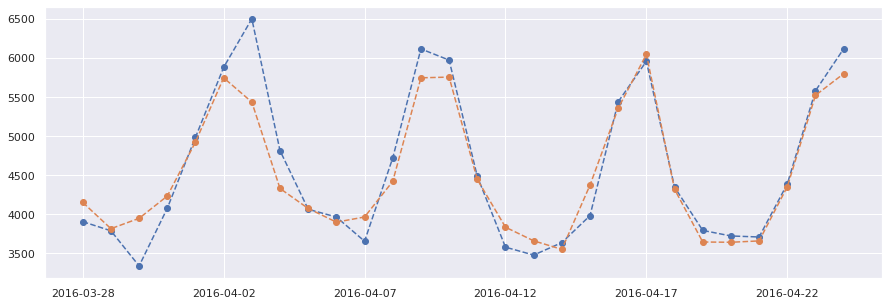

In [ ]:

model = lgb.LGBMRegressor(first_metric_only = True)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          early_stopping_rounds = 10,
          verbose = 0)

forecast = model.predict(test_x)
s1_naive = series[-29:-1].to_numpy()
s7_naive = series[-35:-7].to_numpy()
s30_naive = series[-56:-28].to_numpy()
s365_naive = series[-364:-336].to_numpy()

print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))

series[-test_size:].plot(marker = 'o', linestyle = '--')
plt.plot(forecast, marker = 'o', linestyle = '--')
plt.show()

In [ ]:
trees = [10, 50, 100, 500, 1000, 2000]

results = []
names = []
for i in trees:
    
    params = {
        'n_estimators': i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%3d --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

 10 --- MAE: -385.639 (31.537)
 50 --- MAE: -283.540 (21.324)
100 --- MAE: -285.091 (21.551)
500 --- MAE: -288.237 (21.803)
1000 --- MAE: -288.672 (21.822)


#### **Plotting MAE graphs**

In [ ]:
results = []
names = []
for i in range(1, 11):
    
    params = {
        'max_depth': i,
        'num_leaves': 2**i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%3d --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

In [ ]:
rates = [0.0001, 0.001, 0.01, 0.1, 1.0]

results = []
names = []
for i in rates:
    
    params = {
        'learning_rate': i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%.3f --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

In [ ]:
types = ['gbdt', 'dart', 'goss']

results = []
names = []
for i in types:
    
    params = {
        'boosting_type': i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%s --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()



types = ['gbdt', 'dart', 'goss']

results = []
for i in types:
    
    for j in range(1, 11):
    
        params = {
            'n_estimators': 2000,
            'learning_rate': 0.1,
            'max_depth': j,
            'num_leaves': 2**j,
            'boosting_type': i,
        }

        cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
        scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
        results.append(scores)

        print('%s %d --- MAE: %.3f (%.3f)' % (i, j, np.mean(scores), np.std(scores)))



params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

forecast = model.predict(test_x)
s1_naive = series[-29:-1].to_numpy()
s7_naive = series[-35:-7].to_numpy()
s30_naive = series[-56:-28].to_numpy()
s365_naive = series[-364:-336].to_numpy()

print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))

series[-test_size:].plot(marker = 'o', linestyle = '--')
plt.plot(forecast, marker = 'o', linestyle = '--')
plt.show()

# **End of Hyper Parameter Tuning**